2011-2014 data for analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob
import os
import datetime
import pandas as pd
import netCDF4 as nc
import datetime
#import seaborn as sns tell me import error!!
from salishsea_tools.nowcast import figures
from salishsea_tools import viz_tools, nc_tools, tidetools
from glob import glob
%matplotlib inline

In [2]:
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '25'}
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '30', 'color': 'black',
    'weight': 'medium'
}

In [3]:
import ACTDR

In [4]:
ACTDR.load_dat('SOG_new.dat')

> open  SOG_new.dat
> load CTD_DAT
> load STANDARD_KEYS
> close  SOG_new.dat
> complete


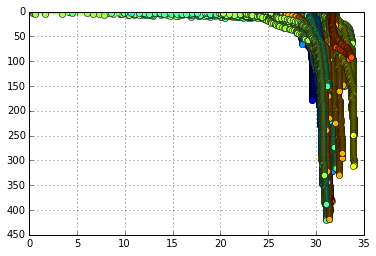

In [5]:
cmap=cm.get_cmap('jet',12)
count=0
for cast in ACTDR.CTD_DAT:
    plt.plot(cast['Salinity'],cast['Depth'],marker='o',c=cmap(cast['Month']-1))
    count=count+1
plt.axis([0,35,450,0])
plt.grid()

In [6]:
bathyy, X, Y = tidetools.get_SS2_bathy_data()

In [7]:
def select_cast_month_more(imin, imax, jmin, jmax, Month):
    """This function was made to select 
        the cast in the SoG region in the
        specific month """
    
    s_cast = []
    for cast in ACTDR.CTD_DAT:
        [x1, y1] = tidetools.find_closest_model_point(cast['Longitude'] , \
        cast['Latitude'],X,Y,bathyy)
        if (x1 < jmax) & (x1 > jmin) & (y1 < imax) & (y1 > imin)  & (cast['Month'] == Month):
            s_cast.append(cast)
    return s_cast

In [8]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return nc.Dataset(filepaths[0])

In [9]:
def compare_cast_SoG_zoomin(imin,imax,jmin,jmax,Month,num):
    month = {'1':{'name': 'Jan'},'2':{'name': 'Feb'},\
    '3':{'name': 'Mar'}, '4':{'name': 'Apr'},'5':{'name': 'May'},\
    '6':{'name': 'Jun'},'7':{'name': 'Jul'},'8':{'name': 'Aug'},\
    '9':{'name': 'Sep'}, '10':{'name': 'Oct'}, '11':{'name': 'Nov'},\
    '12':{'name': 'Dec'}}
    results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
    fig,axs=plt.subplots(1,4,figsize=(50,15))
    #map
    ax=axs[0]
    grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
    lons = grid.variables['nav_lon']
    lats = grid.variables['nav_lat']
    s_cast = select_cast_month_more(imin, imax, jmin, jmax,Month)
    for cast in s_cast:
        if Month != 3:
            sites, =ax.plot(cast['Longitude'],cast['Latitude'],'DodgerBlue',marker='.', label = 'sites')
            ax.legend([sites],['sites'],loc = 1, fontsize = 25)
        elif Month ==3:
            ax.plot(cast['Longitude'],cast['Latitude'],'DodgerBlue',marker='.', label = 'sites')
    viz_tools.plot_coastline(ax, grid, coords = 'map')
    ax.plot(lons[jmin, imin:imax,],lats[jmin, imin:imax],'r-')
    ax.plot(lons[jmax, imin:imax,],lats[jmax, imin:imax,],'r-')
    ax.plot(lons[ jmin:jmax, imin],lats[jmin:jmax, imin],'r-')
    ax.plot(lons[jmin:jmax, imax],lats[jmin:jmax, imax],'r-')    
    ax.set_xlim([-125.5,-122])
    ax.set_ylim([48.5,50.5])
    plt.setp(ax.get_xticklabels(), fontsize=25)
    plt.setp(ax.get_yticklabels(), fontsize=25)
    ax.set_xlabel('Longitude', **axis_font)
    ax.set_ylabel('Latitude', **axis_font)
    
    
    count = 0
    ##prepare nowcasts results
    for cast in s_cast:
        if Month >= 10:
            run_date = datetime.datetime(2014, Month,cast['Day'])
        else:
            run_date = datetime.datetime(2015, Month,cast['Day'])
        # Results dataset location
        results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
        grid_T_hr = results_dataset('1d', 'grid_T', results_dir)
        sal_hr = grid_T_hr.variables['vosaline']
        depth = grid_T_hr.variables['deptht']
        bathyy, X, Y = tidetools.get_SS2_bathy_data()
        [x1, y1] = tidetools.find_closest_model_point(cast['Longitude'] , \
        cast['Latitude'],X,Y,bathyy)
        sal_hr = np.ma.masked_values(sal_hr[0,:,x1,y1], 0)
        ax = axs[1]
        modd, = ax.plot(sal_hr, depth[:], 'MediumBlue',marker = '*')
        ##profile comparison          
        obss, =ax.plot(cast['Salinity'],cast['Depth'],'DarkGreen',marker='o')
        count=count+1
        ax.axis([0,35,400,0])
        ax.grid('on')   
        ax.set_title('Comparison in '+ str(month[num]['name']), **title_font)
        plt.setp(ax.get_xticklabels(), fontsize=25)
        plt.setp(ax.get_yticklabels(), fontsize=25)
        ax.set_xlabel('salinity', **axis_font)
        ax.set_ylabel('depth [m]', **axis_font)
        ax.legend([modd,obss],['mod','obs'],loc = 2, fontsize = 25)
        ax = axs[2]
        mod, = ax.plot(sal_hr, depth[:], 'MediumBlue',marker = '*')
        obs, = ax.plot(cast['Salinity'],cast['Depth'],'DarkGreen', marker='o')
        ax.set_xlim(0, 35)
        ax.set_ylim(80, 0)
        ax.set_title('Zoom in top 80m ',**title_font)
        plt.setp(ax.get_xticklabels(), fontsize=25)
        plt.setp(ax.get_yticklabels(), fontsize=25)
        ax.set_xlabel('salinity', **axis_font)
        ax.set_ylabel('depth [m]', **axis_font)
        ax.grid('on') 
        ax.legend([mod,obs],['mod','obs'],loc = 2, fontsize = 25)
        ax = axs[3]
        mod, = ax.plot(sal_hr, depth[:], 'MediumBlue',marker = '*')
        obs, = ax.plot(cast['Salinity'],cast['Depth'],'DarkGreen', marker='o')
        ax.set_xlim(0, 35)
        ax.set_ylim(20, 0)
        ax.set_title('Zoom in top 20m ',**title_font)
        plt.setp(ax.get_xticklabels(), fontsize=25)
        plt.setp(ax.get_yticklabels(), fontsize=25)
        ax.set_xlabel('salinity', **axis_font)
        ax.set_ylabel('depth [m]', **axis_font)
        ax.grid('on') 
        ax.legend([mod,obs],['mod','obs'],loc = 2, fontsize = 25)
              
    return fig

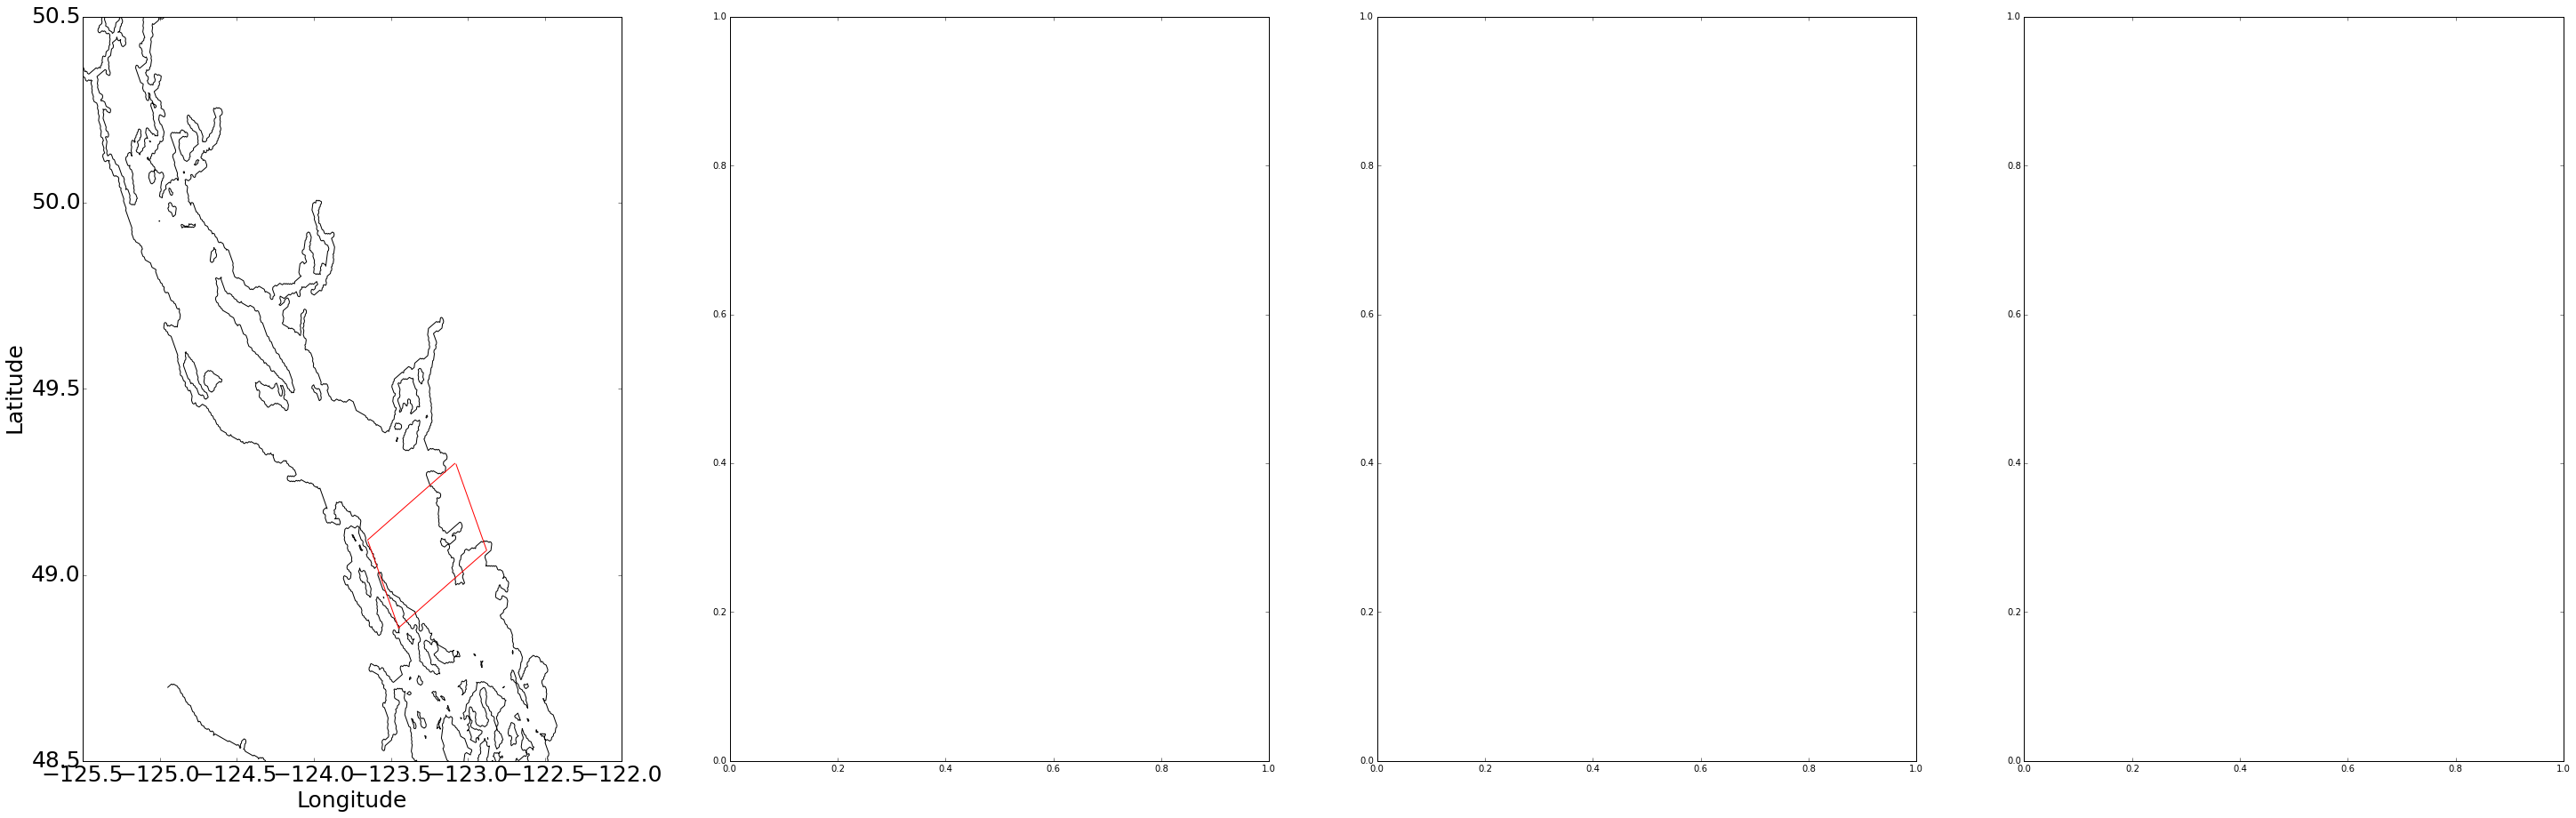

In [10]:
## Oct
fig = compare_cast_SoG_zoomin(240, 350, 390, 450, 10, '10')

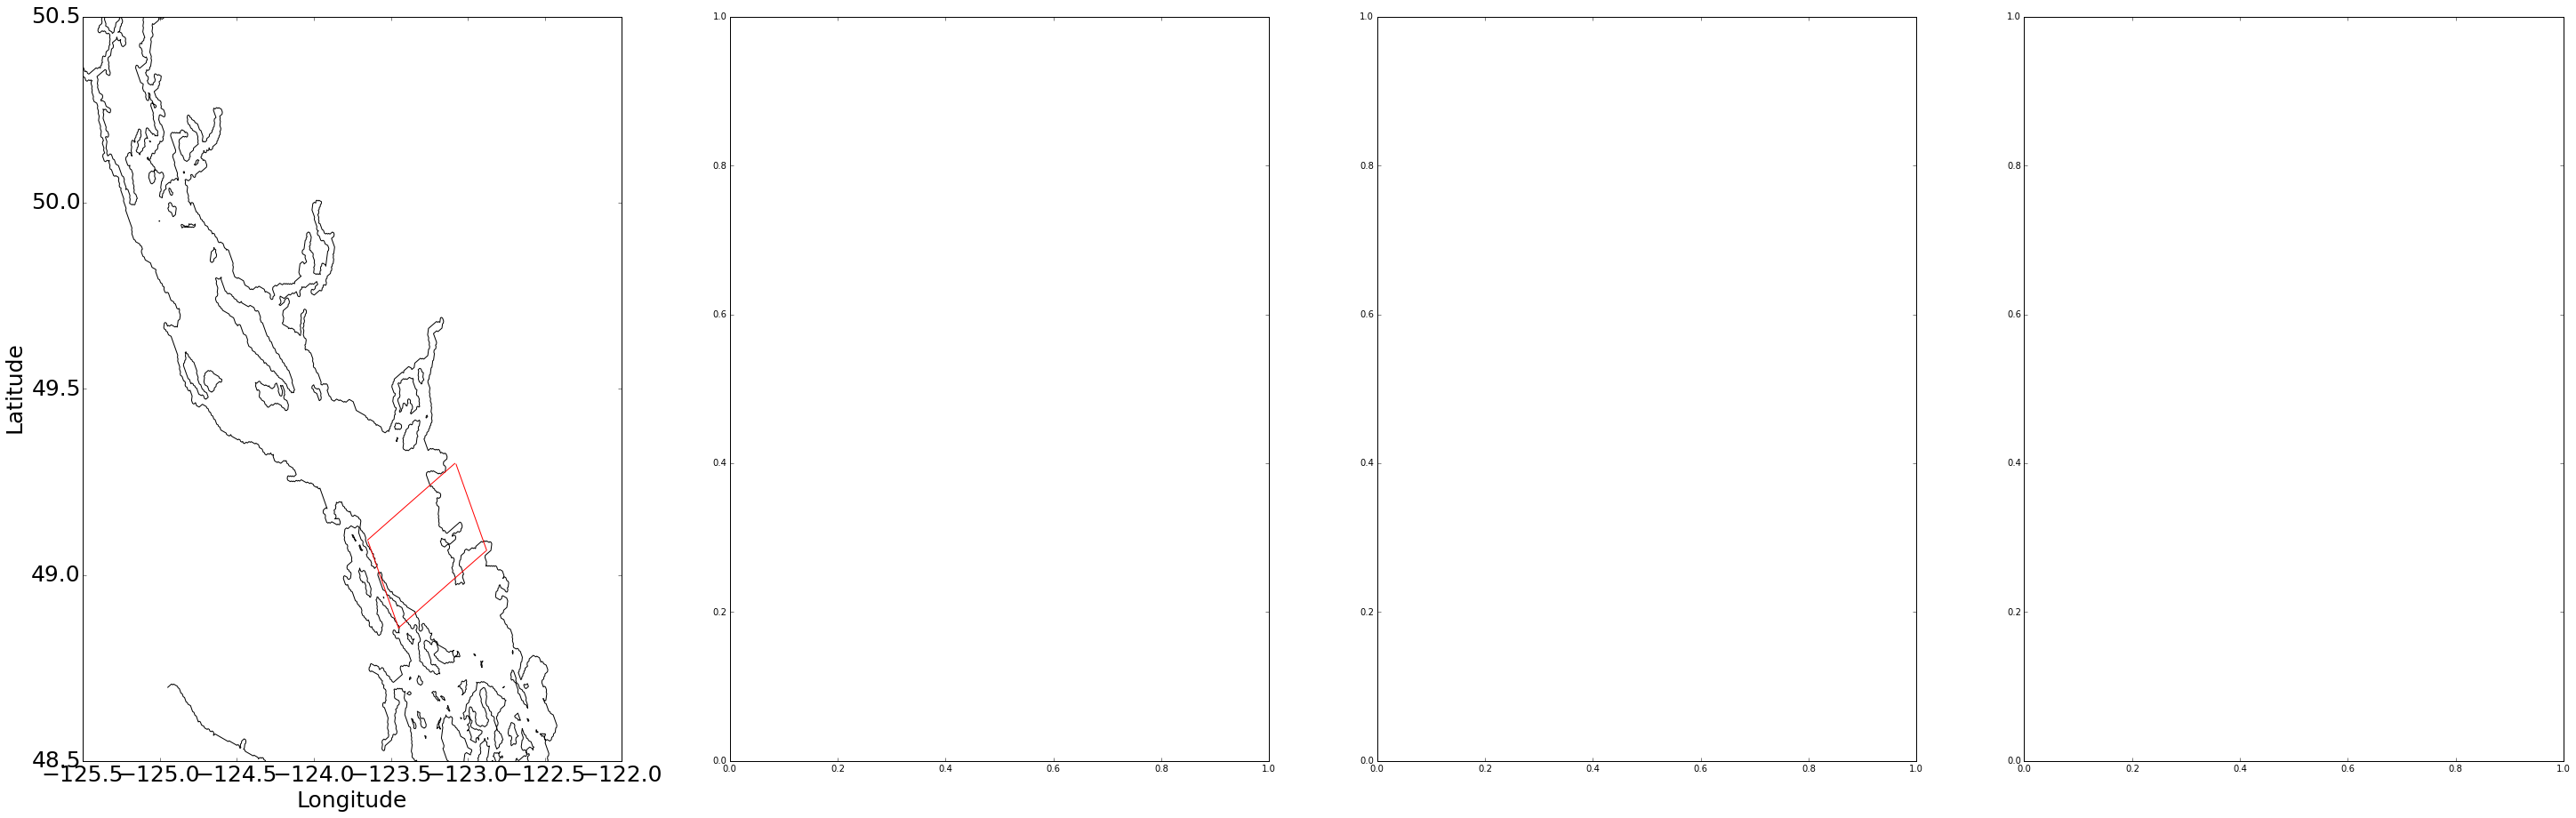

In [11]:
## Nov
fig = compare_cast_SoG_zoomin(240, 350, 390, 450, 11, '11')

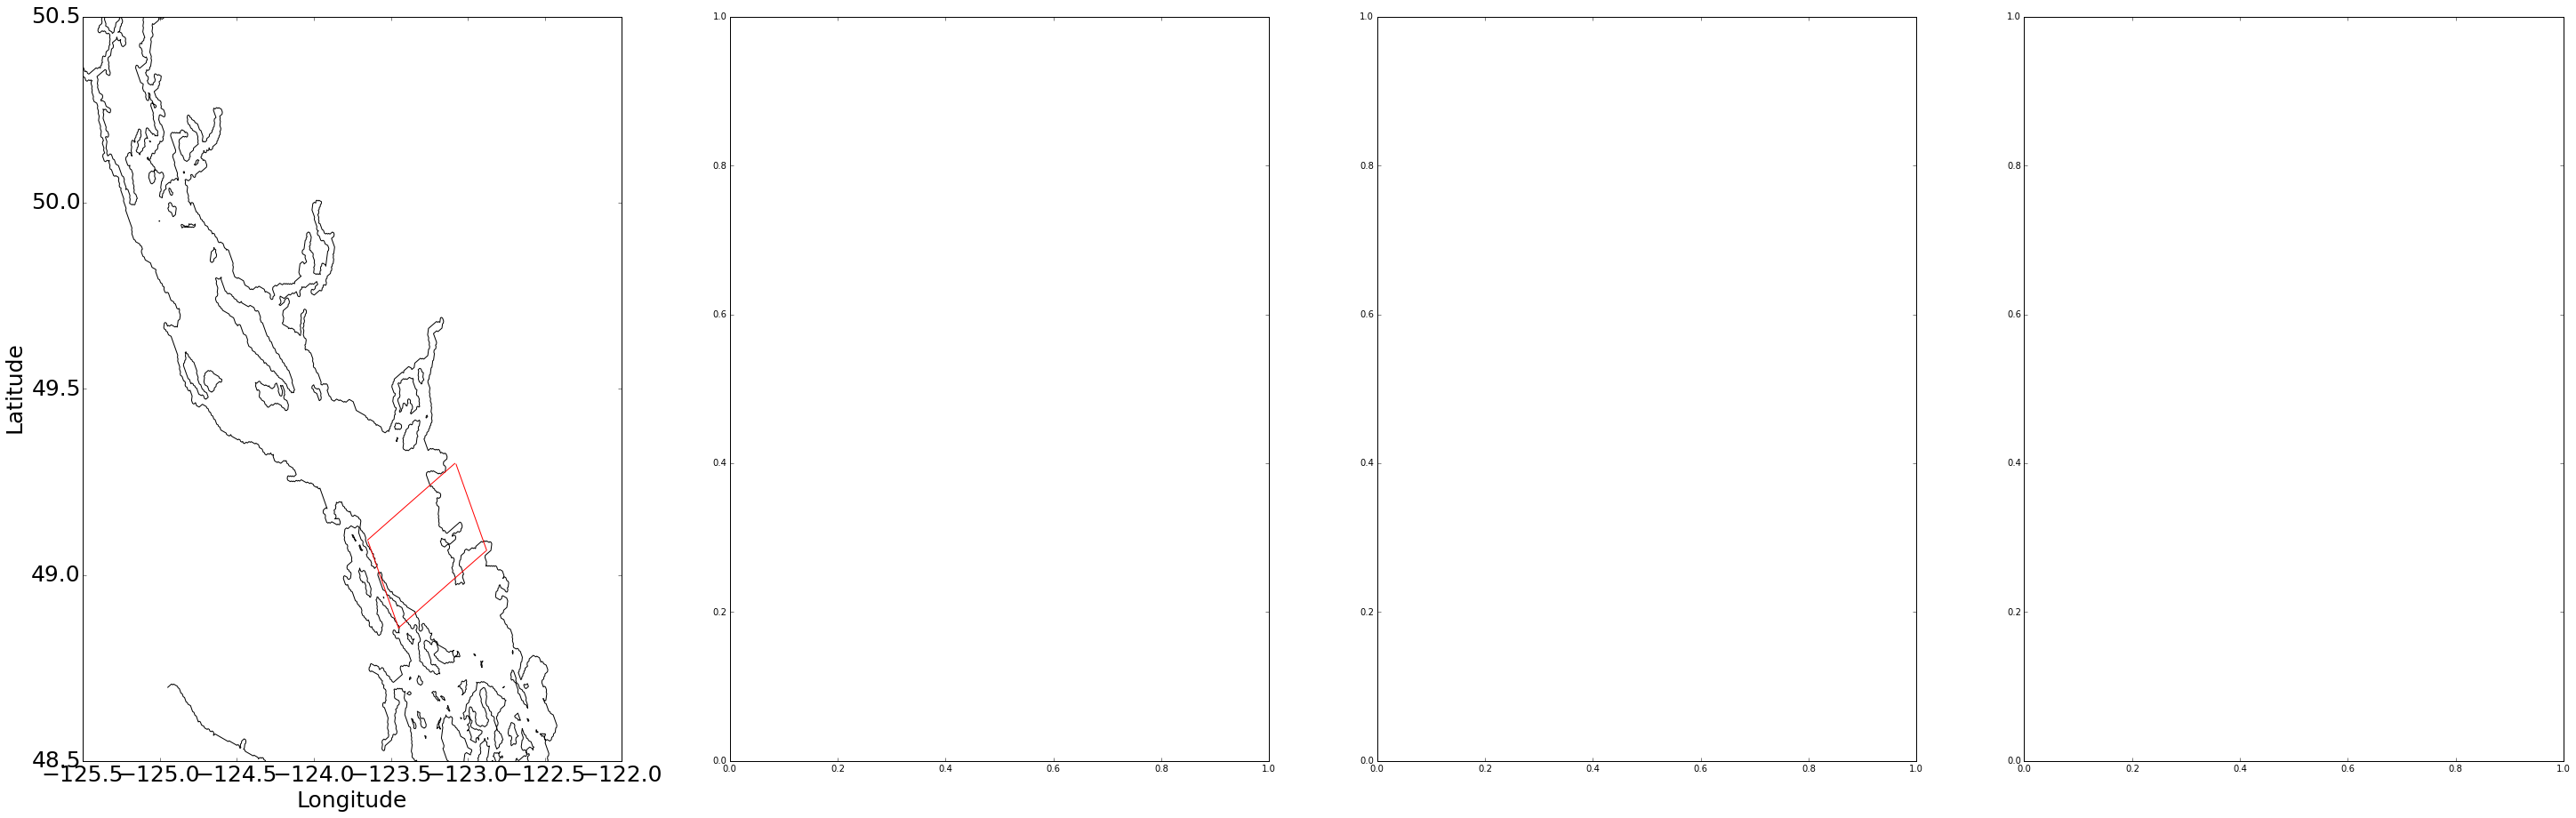

In [12]:
## Dec
fig = compare_cast_SoG_zoomin(240, 350, 390, 450, 12,'12')

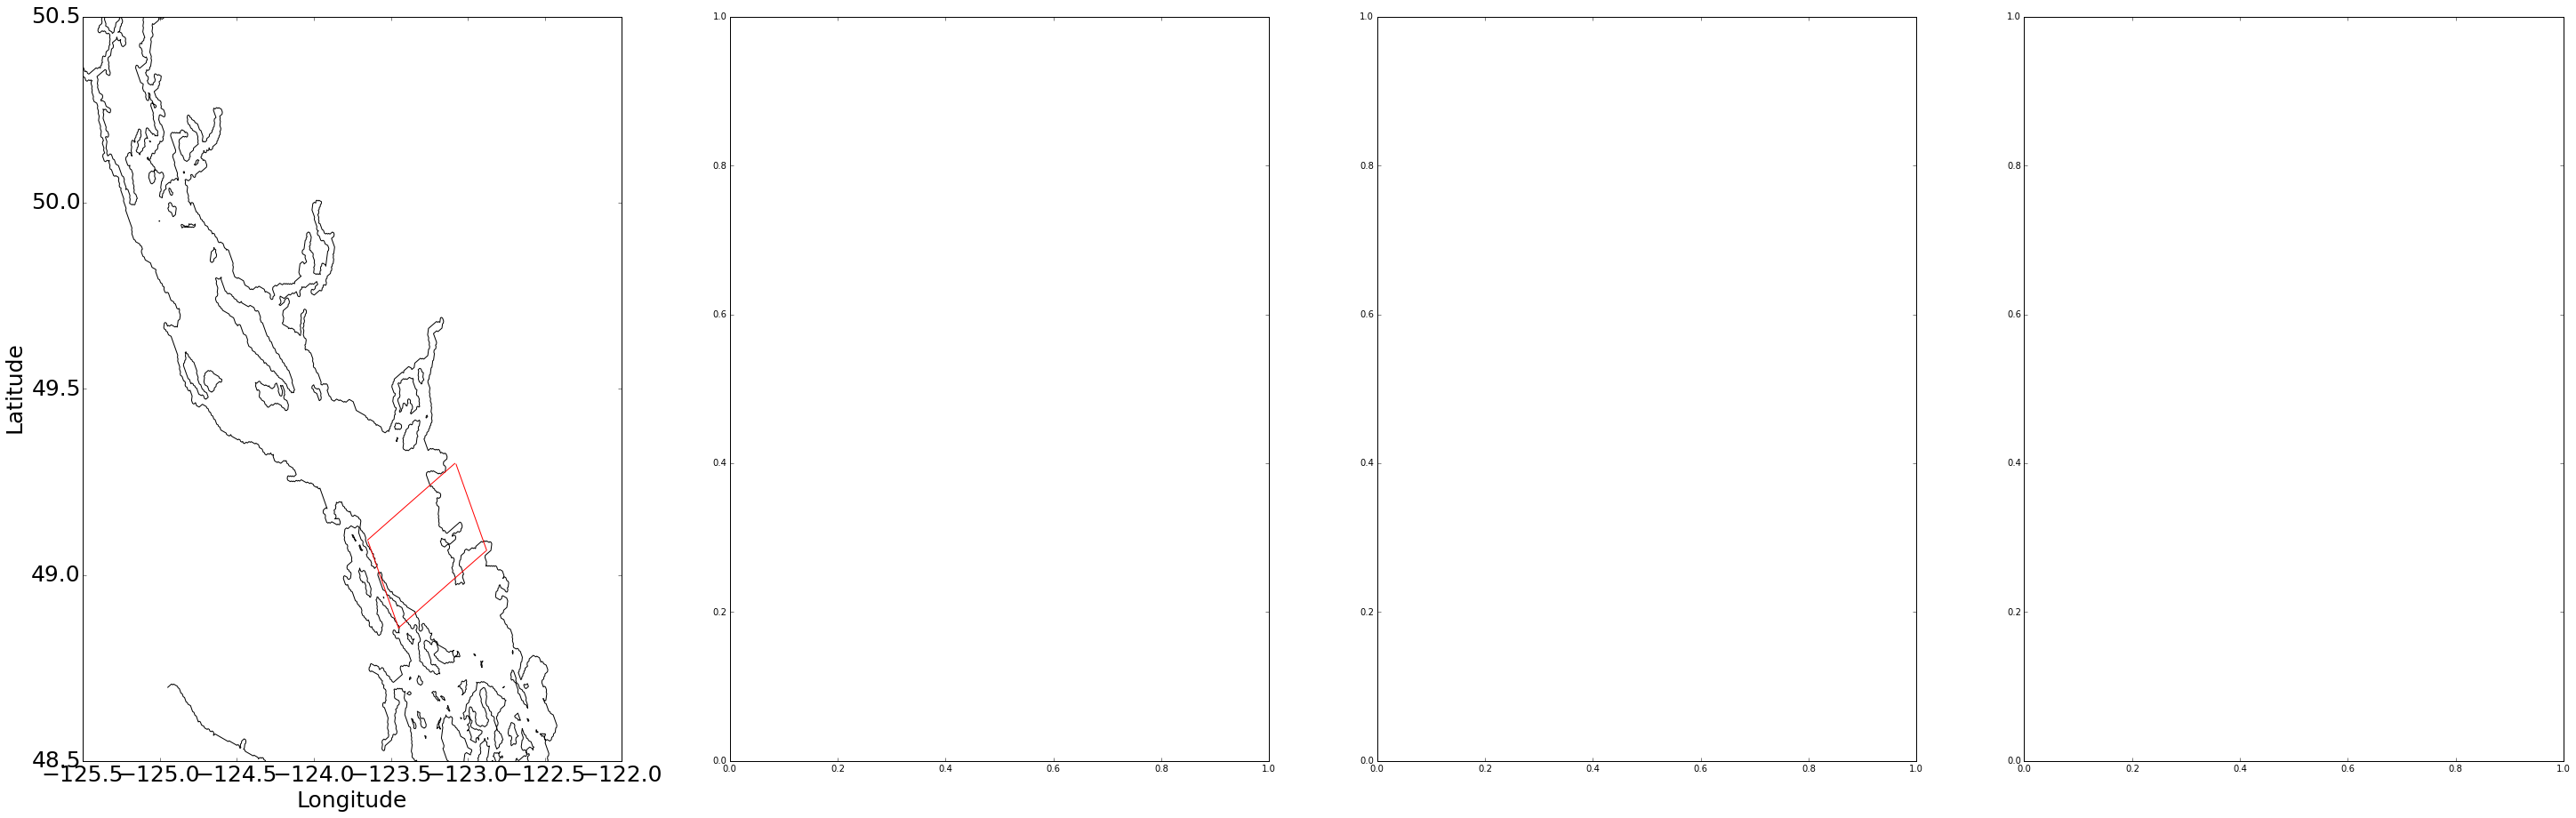

In [13]:
## Jan
fig = compare_cast_SoG_zoomin(240, 350, 390, 450, 1, '1')

* It seems bizzare that there is no data in these three months, will test it further

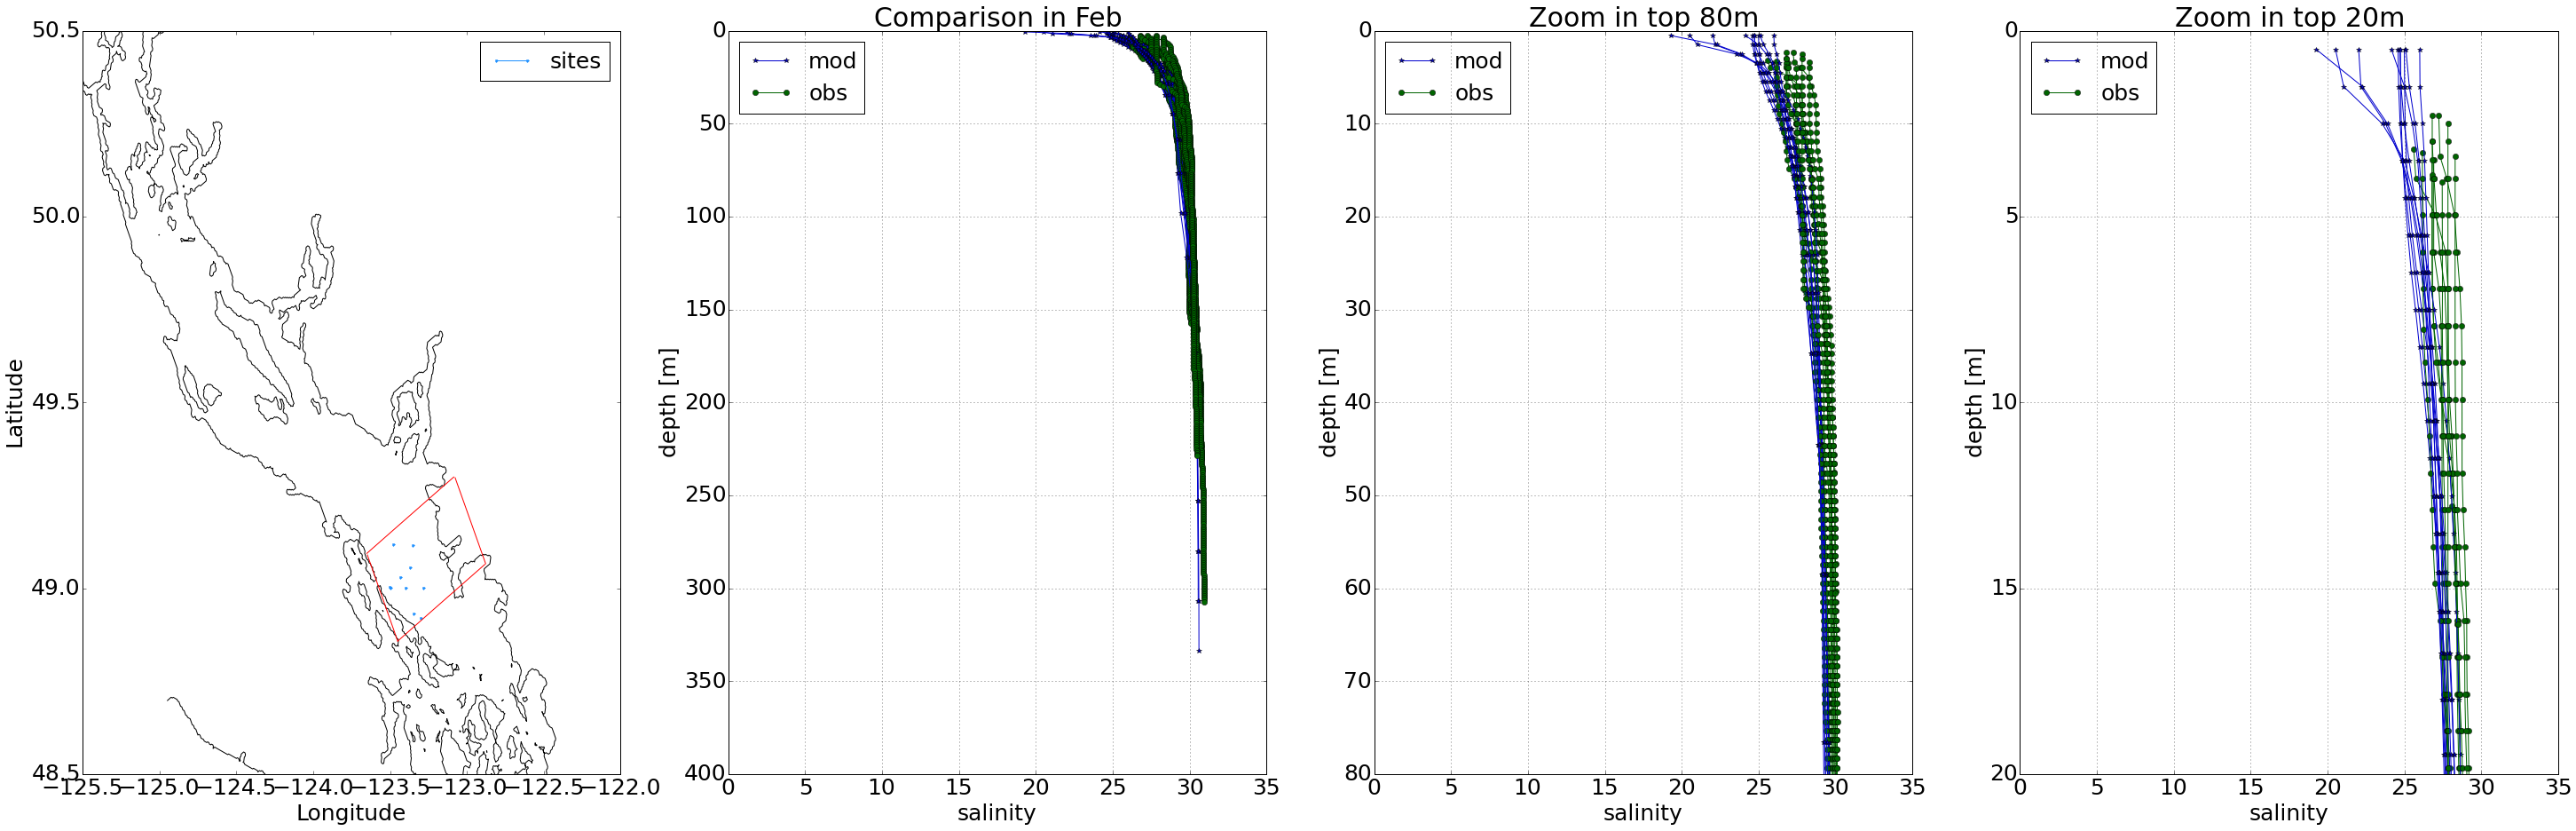

In [14]:
## Feb
fig = compare_cast_SoG_zoomin(240, 350, 390, 450, 2, '2')

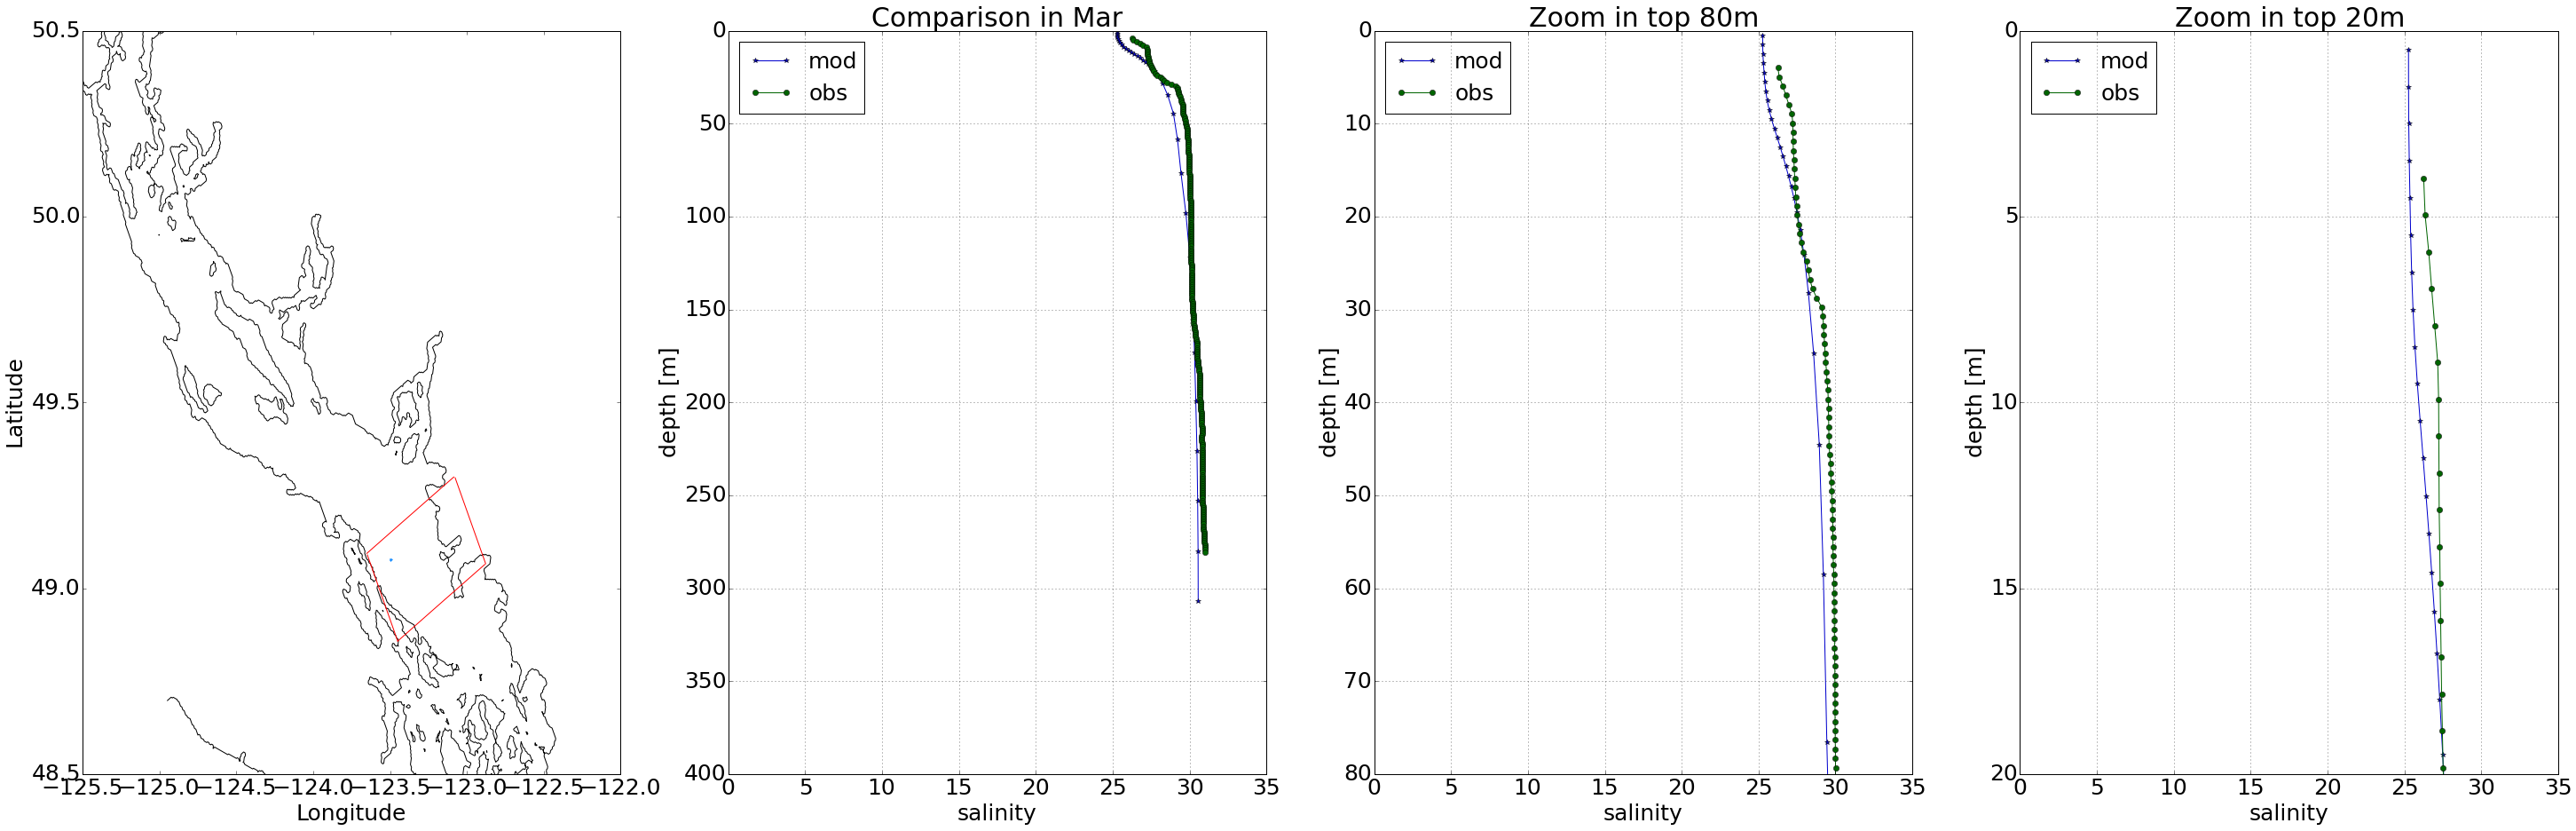

In [15]:
##March
fig = compare_cast_SoG_zoomin(240, 350, 390, 450, 3, '3')

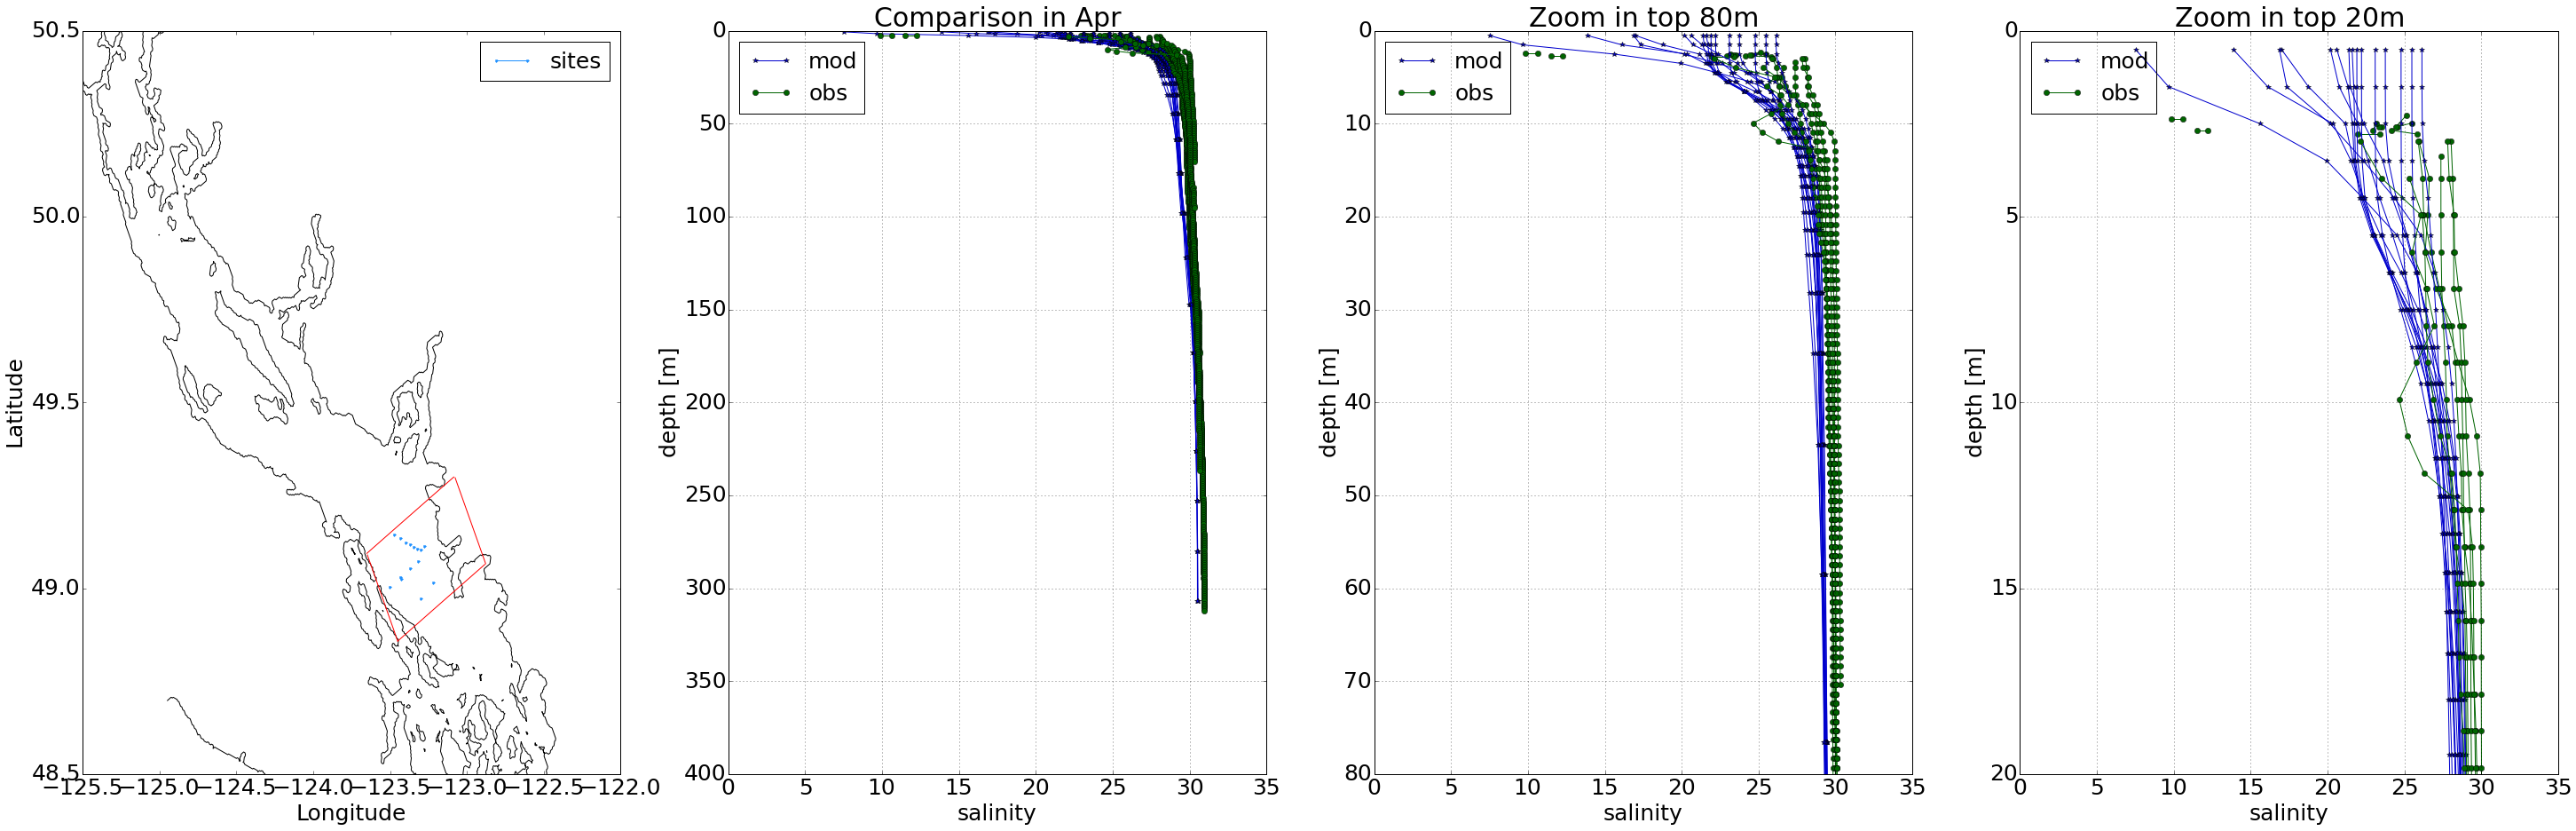

In [16]:
##April
fig = compare_cast_SoG_zoomin(240, 350, 390, 450, 4, '4')

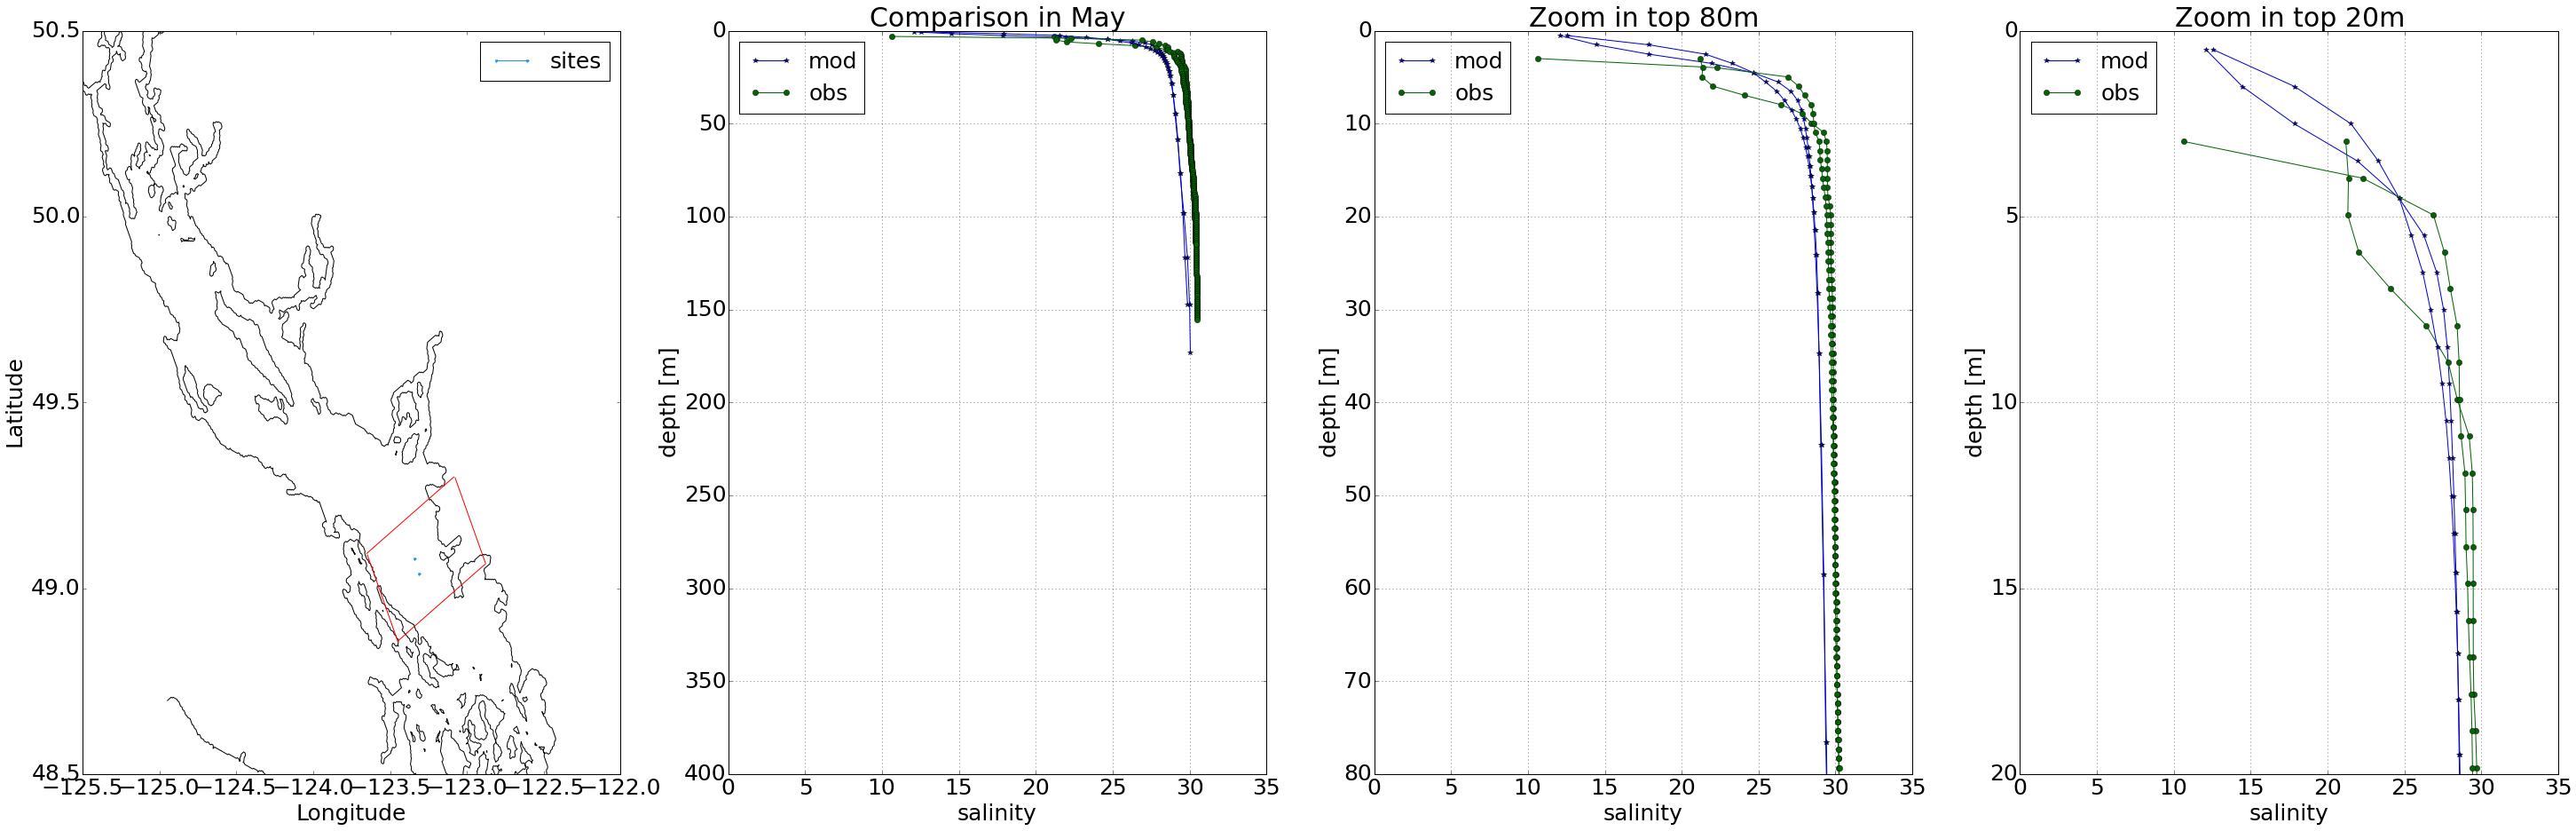

In [17]:
## May
fig = compare_cast_SoG_zoomin(240, 350, 390, 450, 5, '5')

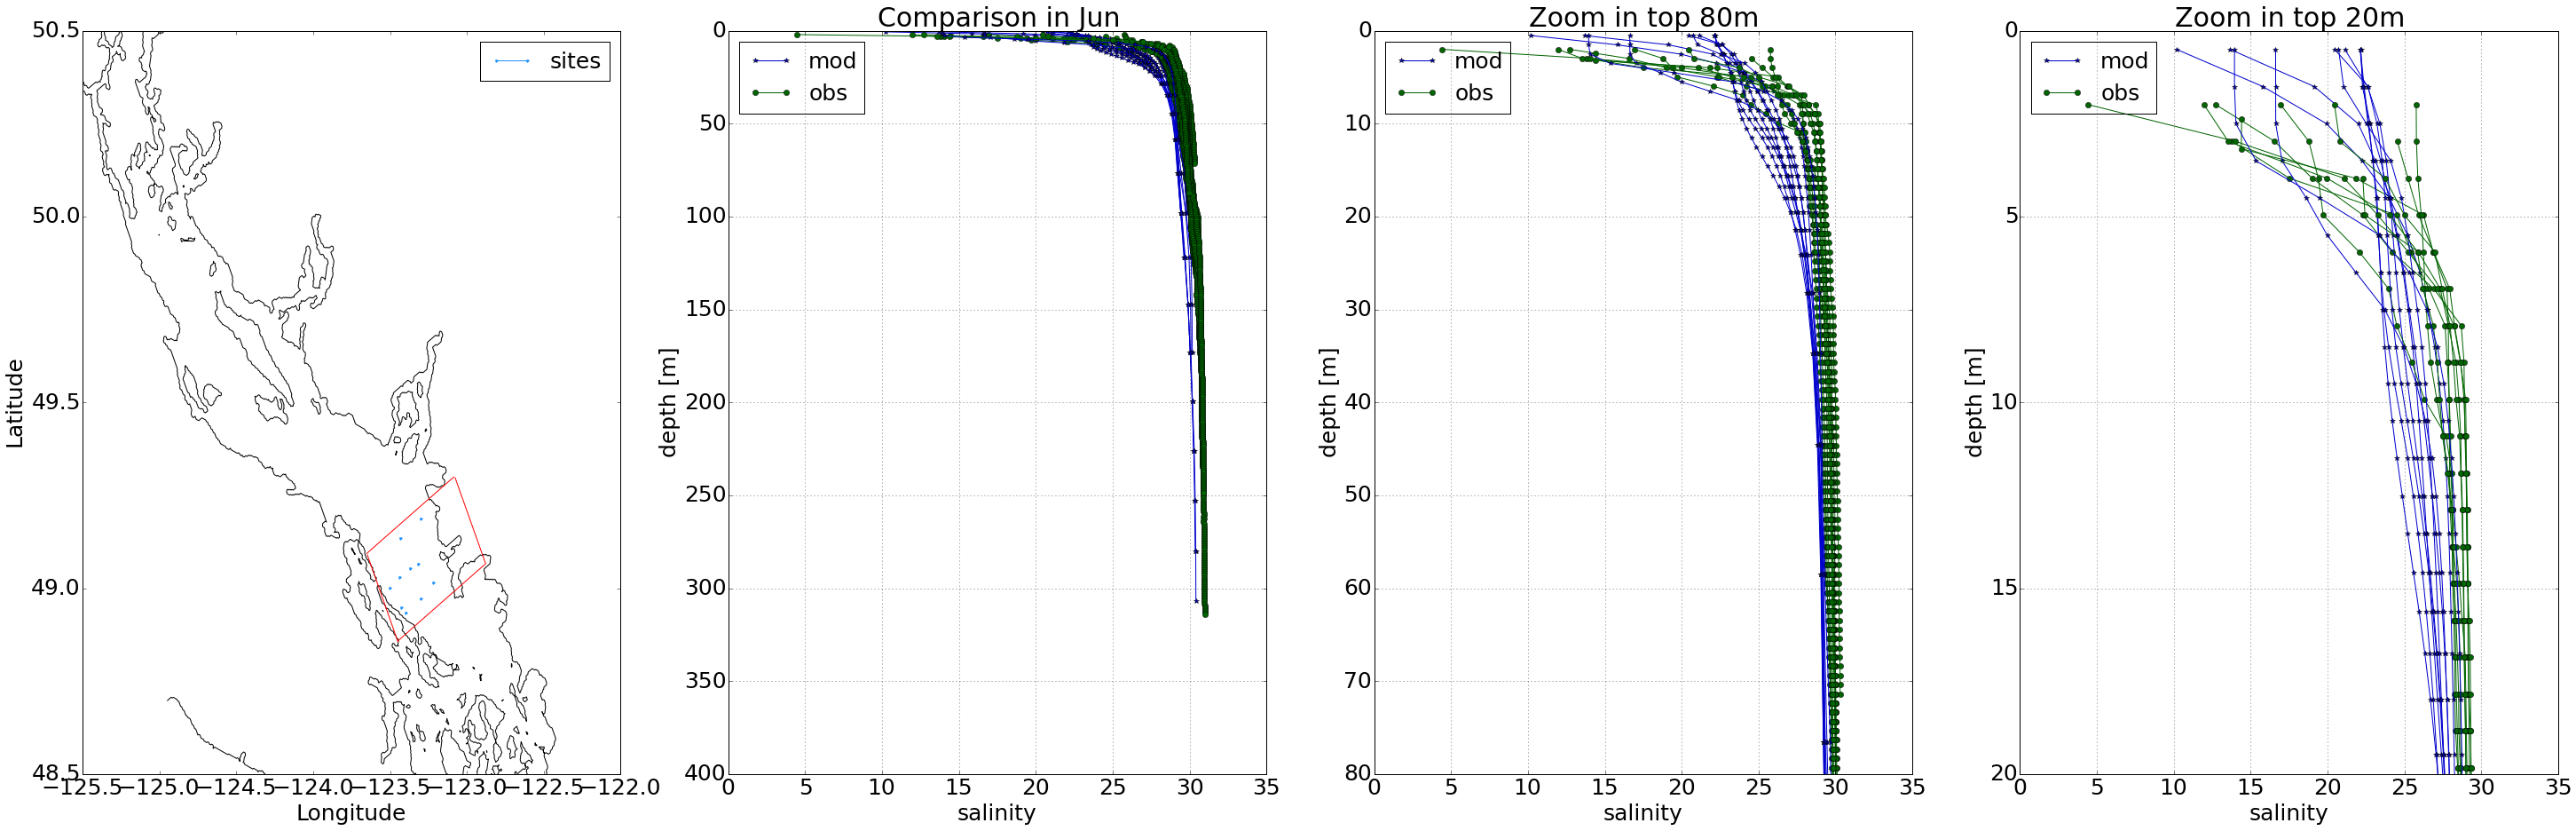

In [18]:
## June
fig = compare_cast_SoG_zoomin(240, 350, 390, 450, 6,'6')

In [19]:
import pandas as pd

In [20]:
data = pd.DataFrame(ACTDR.CTD_DAT)

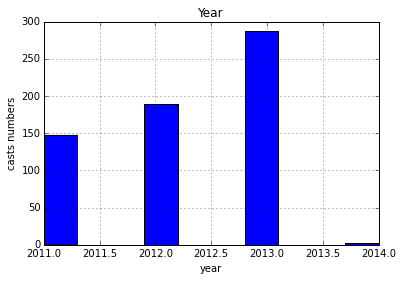

In [21]:
data.hist('Year')
plt.ylabel('casts numbers')
plt.xlabel('year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

In [22]:
data['Year'].max()

2014

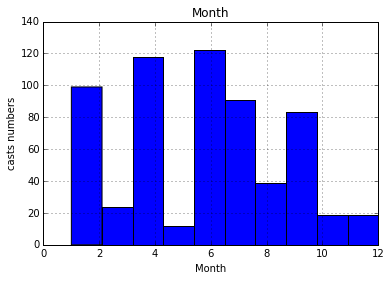

In [23]:
data.hist('Month')
plt.ylabel('casts numbers')
plt.xlabel('Month')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

In [24]:
data['Month'].max()

12

* But how could I get no data of October,November and December???

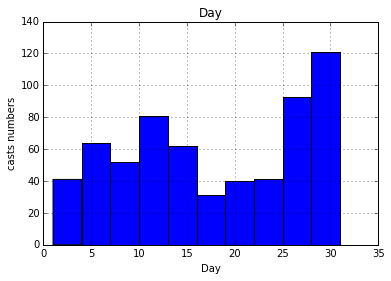

In [25]:
data.hist('Day')
plt.ylabel('casts numbers')
plt.xlabel('Day')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)